# NBody9  Energy conservation

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-NBody9">
             Initial value problem: NBody9</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 
             
<li><a href="#Save-Data">
            Save Data</a></li>  

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq
using DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates,LaTeXStrings
using JLD2, FileIO
#using RecursiveArrayTools

In [2]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [4]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: NBody-9

In [4]:
setprecision(BigFloat, 108);
include("../examples/Nbody.jl")
include("../examples/InitialNBody9.jl")

dt=5
t0=0.0
t1=10^6


u064,Gm64 =InitialNBody9(Float64)
lpp=Gm64
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialNBody9(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp)

q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


mysaveat=1000
vsaveat=100.;

(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64,3}, Array{Float64,1}, Tuple{Float64,Int64}, Array{BigFloat,3}, Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Initial energy

In [4]:
setprecision(BigFloat, 256)

u0256,Gm256=InitialNBody9(BigFloat)

E0=NbodyEnergy(u0256,Gm256)


-9.831951850714509861613682908577622008275351805284600444356653442764997668898217e-12

<a href="#top">Back to the top</a>

## Energy errors

In [5]:
sol1= solve(probdyn64,IRKGL16(),adaptive=false, mixed_precision=false, dt=5,saveat=mysaveat)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  8774711
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          200000
Number of rejected steps:                          0

In [6]:
sol2= solve(probdyn64,IRKGL16(),adaptive=false, mixed_precision=true, dt=5, saveat=mysaveat)
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  907
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          20
Number of rejected steps:                          0

In [7]:
sol11 =solve(probdyn64,Vern9(), abstol=1e-16,reltol=1e-16) #saveat=vsaveat)
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  2034
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          118
Number of rejected steps:                          9

In [8]:
sol21= solve(prob2nd64,DPRKN12(),abstol=1e-16,reltol=1e-16) #saveat=vsaveat)
sol21.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  819
Number of function 2 evaluations:                  49
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          47
Number of rejected steps:                          1

In [9]:
k=1000
ΔE1 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol2.u)./E0.-1
ΔE11 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol11.u[1:k:end])./E0.-1
ΔE21 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol21.u[1:k:end])./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE11))), Float32(maximum(abs.(ΔE21))))

(2.3898193f-16, 2.3898193f-16, 5.5293517f-16, 7.621934f-16)

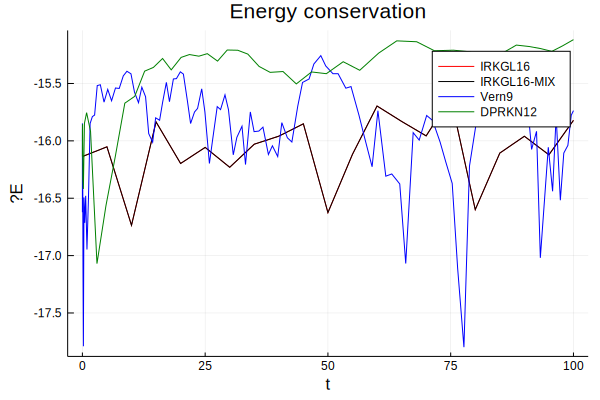

In [10]:
plot(title="Energy conservation", xlabel="t", ylabel="ΔE")
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16", color="red")
plot!(sol2.t,log10.(abs.(ΔE2)), label="IRKGL16-MIX", color="black")
plot!(sol11.t[1:k:end],log10.(abs.(ΔE11)), label="Vern9", color="blue")
plot!(sol21.t[1:k:end],log10.(abs.(ΔE21)), label="DPRKN12", color="green")

<a href="#top">Back to the top</a>

### CPU TIME

In [7]:
s=@btime(solve(probdyn64,IRKGL16(),adaptive=false, mixed_precision=false, dt=5,save_everystep=false));

  360.880 s (3961390047 allocations: 357.04 GiB)


In [ ]:
s=@btime(solve(prob2nd64,DPRKN12(),abstol=1e-16,reltol=1e-16,save_everystep=false));

## Planets orbits

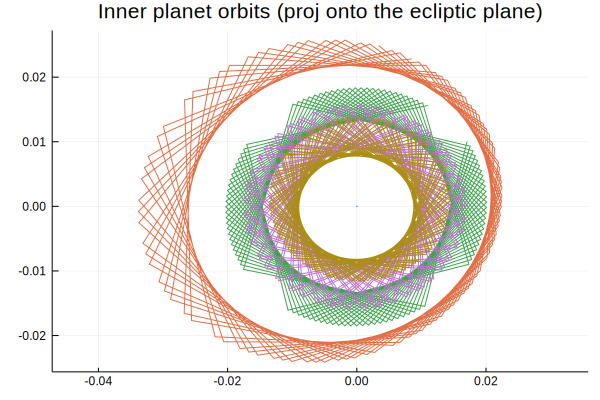

In [16]:
ulist0 = sol1.u
tlist0 = sol1.t

pl = plot(title="Inner planet orbits (proj onto the ecliptic plane)", 
          aspect_ratio=1)

for j = 1:5
 xlist  = map(u->u[2,1,j], ulist0[1:100])
 ylist  = map(u->u[2,2,j], ulist0[1:100])
 pl = plot!(xlist,ylist, label="") # label = bodylist[j])   
end    


plot(pl)

## Save Output Data

In [42]:
save("./Data/output/OutN9BodyEnergy.jld2", "ΔE1", ΔE1, "ΔE2", ΔE2, "ΔE11", ΔE11, "ΔE21", ΔE21,     
                                     "sol1t", sol1.t, "sol2t", sol2.t,
                                      "sol11t", sol11.t[1:k:end], "sol21t", sol21.t[1:k:end])

## Plot for Juliacon2020

In [2]:
sol1t=load("./Data/output/OutN9BodyEnergy.jld2", "sol1t")
ΔE1=load("./Data/output/OutN9BodyEnergy.jld2", "ΔE1")
sol21t=load("./Data/output/OutN9BodyEnergy.jld2", "sol21t")
ΔE21=load("./Data/output/OutN9BodyEnergy.jld2", "ΔE21");

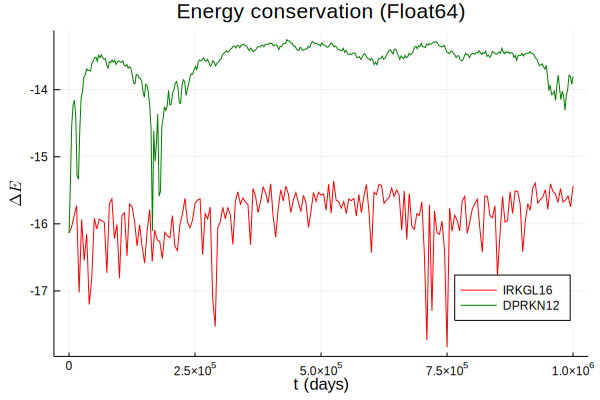

In [15]:
plot(title="Energy conservation (Float64)", xlabel="t (days)", ylabel=L"\Delta E")    
plot!(sol1t,log10.(abs.(ΔE1)), label="IRKGL16", color="red",legend=:bottomright)
plot!(sol21t,log10.(abs.(ΔE21)), label="DPRKN12", color="green")

In [14]:
now()

2020-06-30T17:43:22.108